In [4]:
# ------------------------------------------------------------------
# Step 0 – Imports, File Paths, and Setup (Demographics)
# ------------------------------------------------------------------
import os
import sys
import pandas as pd
import geopandas as gpd

# Optional: if you want to add custom script tools later
script_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/scripts"
if script_dir not in sys.path:
    sys.path.append(script_dir)

# Define base data directory
data_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/raw"
demo_dir = os.path.join(data_dir, "demographics")

# Define demographic file paths
general_health_path = os.path.join(demo_dir, "census2021-ts037-lsoa.csv")
imd_path = os.path.join(demo_dir, "Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv")
ruc_path = os.path.join(demo_dir, "Rural_Urban_Classification_(2021)_of_LSOAs_in_EW.csv")

# Base GeoPackage
gpkg_path = os.path.join(data_dir, "LSOA_5-year_segment_master.gpkg")

# Confirm file existence
for path in [general_health_path, imd_path, ruc_path, gpkg_path]:
    assert os.path.exists(path), f"Missing file: {path}"

In [7]:
# ------------------------------------------------------------------
# Step 1 – Column Inspection and Unique Value Check
# ------------------------------------------------------------------
def print_columns_and_uniques(filepath, key_col=None, classifier_cols=None, nrows=5):
    print(f"\nColumns in: {os.path.basename(filepath)}")
    try:
        df = pd.read_csv(filepath, nrows=None)  # Full read for uniqueness check
        print("Column names:", df.columns.tolist())
        print(df.head(nrows))
        
        if key_col and key_col in df.columns:
            unique_vals = df[key_col].nunique()
            print(f"Unique values in '{key_col}': {unique_vals}")
        else:
            print("No key column provided or not found.")
        
        if classifier_cols:
            for col in classifier_cols:
                if col in df.columns:
                    unique_labels = df[col].dropna().unique()
                    print(f"Unique values in '{col}': {list(unique_labels)}")
                else:
                    print(f"Column '{col}' not found in dataset.")
    except Exception as e:
        print(f"Could not read {filepath}: {e}")

# Run checks with relevant identifiers and classifiers
print_columns_and_uniques(general_health_path, key_col="geography code")
print_columns_and_uniques(imd_path, key_col="LSOA11CD")
print_columns_and_uniques(
    ruc_path,
    key_col="LSOA21CD",
    classifier_cols=["Urban_rural_flag", "RUC21NM"]
)



Columns in: census2021-ts037-lsoa.csv
Column names: ['date', 'geography', 'geography code', 'General health: Total: All usual residents', 'General health: Very good health', 'General health: Good health', 'General health: Fair health', 'General health: Bad health', 'General health: Very bad health']
   date                  geography geography code  \
0  2021        City of London 001A      E01000001   
1  2021        City of London 001B      E01000002   
2  2021        City of London 001C      E01000003   
3  2021        City of London 001E      E01000005   
4  2021  Barking and Dagenham 016A      E01000006   

   General health: Total: All usual residents  \
0                                        1475   
1                                        1384   
2                                        1613   
3                                        1100   
4                                        1847   

   General health: Very good health  General health: Good health  \
0               

In [8]:
# ------------------------------------------------------------------
# Step 2 – Filter Health and RUC Data Using LSOAs from GeoPackage
# ------------------------------------------------------------------

# Paths (assumed previously defined)
# general_health_path, ruc_path, gpkg_path

# Load LSOA GeoPackage and extract LSOA codes
gdf_lsoa = gpd.read_file(gpkg_path)
lsoa_list = gdf_lsoa["lsoa21cd"].unique().tolist()
print(f"Loaded {len(lsoa_list)} LSOAs from GeoPackage")

# Load General Health data
health_df = pd.read_csv(general_health_path)
health_df.rename(columns={"geography code": "lsoa21cd"}, inplace=True)
health_filtered = health_df[health_df["lsoa21cd"].isin(lsoa_list)].copy()
print(f"Filtered General Health rows: {len(health_filtered)}")

# Load Rural/Urban Classification data
ruc_df = pd.read_csv(ruc_path)
ruc_df.rename(columns={"LSOA21CD": "lsoa21cd"}, inplace=True)
ruc_filtered = ruc_df[ruc_df["lsoa21cd"].isin(lsoa_list)].copy()
print(f"Filtered RUC rows: {len(ruc_filtered)}")


Loaded 3451 LSOAs from GeoPackage
Filtered General Health rows: 3451
Filtered RUC rows: 3451


In [11]:
# ------------------------------------------------------------------
# Step 3 – Subset Columns and Export Filtered CSVs
# ------------------------------------------------------------------

# Define output directory
output_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed"

# Step 3a – Subset required columns
health_cols = [
    "lsoa21cd",
    "General health: Total: All usual residents",
    "General health: Very good health",
    "General health: Good health",
    "General health: Fair health",
    "General health: Bad health",
    "General health: Very bad health"
]
ruc_cols = ["lsoa21cd", "RUC21NM", "Urban_rural_flag"]

health_subset = health_filtered[health_cols].copy()
ruc_subset = ruc_filtered[ruc_cols].copy()

# Step 3b – Define output file paths
health_out_path = os.path.join(output_dir, "filtered_general_health_lsoas.csv")
ruc_out_path = os.path.join(output_dir, "filtered_rural_urban_lsoas.csv")

# Step 3c – Export CSVs
health_subset.to_csv(health_out_path, index=False)
ruc_subset.to_csv(ruc_out_path, index=False)

# Step 3d – Preview exported files
print("Preview of exported General Health CSV:")
print(health_subset.head())

print("\nPreview of exported Rural/Urban CSV:")
print(ruc_subset.head())


Preview of exported General Health CSV:
        lsoa21cd  General health: Total: All usual residents  \
13300  E01014014                                        1848   
13317  E01014031                                        1585   
13318  E01014032                                        1504   
13322  E01014036                                        1681   
13343  E01014057                                        1898   

       General health: Very good health  General health: Good health  \
13300                               941                          634   
13317                               745                          541   
13318                               762                          484   
13322                               730                          644   
13343                               911                          651   

       General health: Fair health  General health: Bad health  \
13300                          217                          42   
13317     

In [12]:
# ------------------------------------------------------------------
# Step 4 – Prepare IMD Dataset
# ------------------------------------------------------------------

# Load IMD lookup file
imd_df = pd.read_csv(imd_path)
print("IMD raw columns:")
print(imd_df.columns.tolist())
print(imd_df.head())

# Rename LSOA code column for consistency
imd_df.rename(columns={"LSOA11CD": "lsoa21cd"}, inplace=True)

# Keep only LSOA code and IMD score
imd_df = imd_df[["lsoa21cd", "IMD19"]].copy()
print("\nIMD cleaned preview:")
print(imd_df.head())

# Merge with GeoPackage LSOAs (direct match)
gdf_imd_merge = gdf_lsoa.merge(imd_df, on="lsoa21cd", how="left")
print(f"\nGeoDataFrame with IMD merged: {len(gdf_imd_merge)} rows")

# Identify unmatched rows (no IMD score)
missing_imd = gdf_imd_merge[gdf_imd_merge["IMD19"].isna()]
print(f"\nUnmatched LSOAs missing IMD: {len(missing_imd)}")
print(missing_imd[["lsoa21cd"]].head())


IMD raw columns:
['FID', 'LSOA11CD', 'LSOA11NM', 'LAD19CD', 'LAD19NM', 'IMD19']
   FID   LSOA11CD                   LSOA11NM    LAD19CD               LAD19NM  \
0    1  E01000001        City of London 001A  E09000001        City of London   
1    2  E01000104  Barking and Dagenham 014B  E09000002  Barking and Dagenham   
2    3  E01000205                Barnet 035A  E09000003                Barnet   
3    4  E01000002        City of London 001B  E09000001        City of London   
4    5  E01000003        City of London 001C  E09000001        City of London   

   IMD19  
0  29199  
1   6002  
2  27397  
3  30379  
4  14915  

IMD cleaned preview:
    lsoa21cd  IMD19
0  E01000001  29199
1  E01000104   6002
2  E01000205  27397
3  E01000002  30379
4  E01000003  14915

GeoDataFrame with IMD merged: 3451 rows

Unmatched LSOAs missing IMD: 245
     lsoa21cd
16  E01034274
17  E01034278
24  E01034281
32  E01034277
34  E01034273


In [13]:
# ------------------------------------------------------------------
# Step 5 – Nearest Neighbour Imputation for Missing IMD (k=3)
# ------------------------------------------------------------------
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Create centroids for all LSOAs
gdf_imd_merge["centroid"] = gdf_imd_merge.geometry.centroid
gdf_imd_merge["x"] = gdf_imd_merge.centroid.x
gdf_imd_merge["y"] = gdf_imd_merge.centroid.y

# Separate matched and unmatched sets
matched = gdf_imd_merge[~gdf_imd_merge["IMD19"].isna()].copy()
unmatched = gdf_imd_merge[gdf_imd_merge["IMD19"].isna()].copy()

print(f"Matched LSOAs with IMD: {len(matched)}")
print(f"Unmatched LSOAs: {len(unmatched)}")

# Fit kNN model on matched coordinates
knn = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
knn.fit(matched[["x", "y"]])

# Find 3 nearest neighbours for each unmatched LSOA
distances, indices = knn.kneighbors(unmatched[["x", "y"]])

# Assign mean IMD19 from 3 nearest neighbours
imputed_values = []
for i, row in enumerate(unmatched.itertuples()):
    neighbours = matched.iloc[indices[i]]
    imd_estimate = neighbours["IMD19"].mean()
    imputed_values.append(imd_estimate)

# Add imputed values
unmatched["IMD19"] = imputed_values
unmatched["imd_source"] = "nn_imputed"

# Flag matched rows as exact
matched["imd_source"] = "exact"

# Combine back together
gdf_imd_complete = pd.concat([matched, unmatched], axis=0).sort_values("lsoa21cd").reset_index(drop=True)

# Preview
print("\nPreview of final IMD-complete dataset:")
print(gdf_imd_complete[["lsoa21cd", "IMD19", "imd_source"]].head())
print(f"\nTotal rows in final table: {len(gdf_imd_complete)}")
print(f"IMD missing after imputation: {gdf_imd_complete['IMD19'].isna().sum()}")


Matched LSOAs with IMD: 3206
Unmatched LSOAs: 245

Preview of final IMD-complete dataset:
    lsoa21cd    IMD19 imd_source
0  E01014014  13636.0      exact
1  E01014031  13631.0      exact
2  E01014032  16442.0      exact
3  E01014036  23031.0      exact
4  E01014057  13591.0      exact

Total rows in final table: 3451
IMD missing after imputation: 0


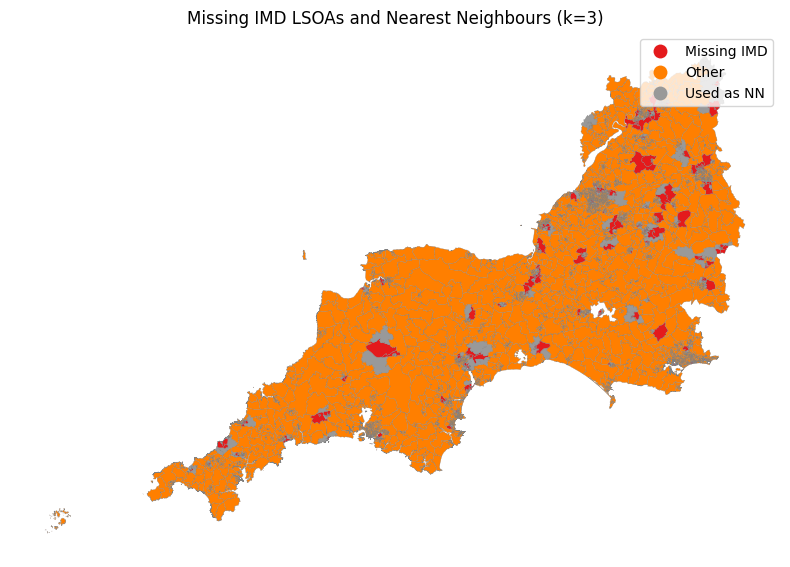

In [14]:
# ------------------------------------------------------------------
# Visual Check – Missing IMD LSOAs and Their Nearest Neighbours
# ------------------------------------------------------------------
import matplotlib.pyplot as plt

# Create a copy for plotting
plot_gdf = gdf_imd_merge.copy()

# Index original LSOAs
plot_gdf = plot_gdf.set_index("lsoa21cd")

# Get geometry for unmatched (missing IMD)
missing_geom = unmatched.set_index("lsoa21cd")[["geometry"]]

# Flatten and collect all 3NN neighbour LSOA codes
nn_lsoas = matched.iloc[indices.flatten()].copy()
nn_lsoas["from_missing"] = np.repeat(unmatched["lsoa21cd"].values, 3)
nn_lsoas_ids = nn_lsoas["lsoa21cd"].unique()

# Flag the categories
plot_gdf["plot_flag"] = "Other"
plot_gdf.loc[missing_geom.index, "plot_flag"] = "Missing IMD"
plot_gdf.loc[nn_lsoas_ids, "plot_flag"] = "Used as NN"

# Plot
fig, ax = plt.subplots(figsize=(8, 10))
plot_gdf.plot(ax=ax, column="plot_flag", legend=True, cmap="Set1", linewidth=0.2, edgecolor="grey")
ax.set_title("Missing IMD LSOAs and Nearest Neighbours (k=3)")
ax.axis("off")
plt.tight_layout()
plt.show()


In [15]:
# ------------------------------------------------------------------
# Step 6 – Export Final IMD-Enhanced Table (Minimal Format)
# ------------------------------------------------------------------

# Define output path
imd_export_path = os.path.join(
    output_dir,
    "lsoa_imd19_complete.csv"
)

# Select only required columns
imd_export_df = gdf_imd_complete[["lsoa21cd", "IMD19"]].copy()

# Export to CSV
imd_export_df.to_csv(imd_export_path, index=False)

# Preview
print("Preview of exported IMD CSV:")
print(imd_export_df.head())
print(f"\nSaved to: {imd_export_path}")


Preview of exported IMD CSV:
    lsoa21cd    IMD19
0  E01014014  13636.0
1  E01014031  13631.0
2  E01014032  16442.0
3  E01014036  23031.0
4  E01014057  13591.0

Saved to: /Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/lsoa_imd19_complete.csv
